# Objectworld RL MDP Environment

In [ ]:
import numpy as np
import numpy.random as rn
import math
from itertools import product
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Gridworld

Implements the gridworld MDP. Matthew Alger, 2015.

In [ ]:
class Gridworld(object):
    """
    Gridworld MDP.
    """

    def __init__(self, grid_size, wind, discount):
        """
        grid_size: Grid size. int.
        wind: Chance of moving randomly. float.
        discount: MDP discount. float.
        -> Gridworld
        """

        self.actions = ((1, 0), (0, 1), (-1, 0), (0, -1))
        self.n_actions = len(self.actions)
        self.n_states = grid_size**2
        self.grid_size = grid_size
        self.wind = wind
        self.discount = discount

        # Preconstruct the transition probability array.
        self.transition_probability = np.array(
            [[[self._transition_probability(i, j, k)
               for k in range(self.n_states)]
              for j in range(self.n_actions)]
             for i in range(self.n_states)])

    def __str__(self):
        return "Gridworld({}, {}, {})".format(self.grid_size, self.wind,
                                              self.discount)

    def feature_vector(self, i, feature_map="ident"):
        """
        Get the feature vector associated with a state integer.

        i: State int.
        feature_map: Which feature map to use (default ident). String in {ident,
            coord, proxi}.
        -> Feature vector.
        """

        if feature_map == "coord":
            f = np.zeros(self.grid_size)
            x, y = i % self.grid_size, i // self.grid_size
            f[x] += 1
            f[y] += 1
            return f
        if feature_map == "proxi":
            f = np.zeros(self.n_states)
            x, y = i % self.grid_size, i // self.grid_size
            for b in range(self.grid_size):
                for a in range(self.grid_size):
                    dist = abs(x - a) + abs(y - b)
                    f[self.point_to_int((a, b))] = dist
            return f
        # Assume identity map.
        f = np.zeros(self.n_states)
        f[i] = 1
        return f

    def feature_matrix(self, feature_map="ident"):
        """
        Get the feature matrix for this gridworld.

        feature_map: Which feature map to use (default ident). String in {ident,
            coord, proxi}.
        -> NumPy array with shape (n_states, d_states).
        """

        features = []
        for n in range(self.n_states):
            f = self.feature_vector(n, feature_map)
            features.append(f)
        return np.array(features)

    def int_to_point(self, i):
        """
        Convert a state int into the corresponding coordinate.

        i: State int.
        -> (x, y) int tuple.
        """

        return (i % self.grid_size, i // self.grid_size)

    def point_to_int(self, p):
        """
        Convert a coordinate into the corresponding state int.

        p: (x, y) tuple.
        -> State int.
        """

        return p[0] + p[1]*self.grid_size

    def neighbouring(self, i, k):
        """
        Get whether two points neighbour each other. Also returns true if they
        are the same point.

        i: (x, y) int tuple.
        k: (x, y) int tuple.
        -> bool.
        """

        return abs(i[0] - k[0]) + abs(i[1] - k[1]) <= 1

    def _transition_probability(self, i, j, k):
        """
        Get the probability of transitioning from state i to state k given
        action j.

        i: State int.
        j: Action int.
        k: State int.
        -> p(s_k | s_i, a_j)
        """

        xi, yi = self.int_to_point(i)
        xj, yj = self.actions[j]
        xk, yk = self.int_to_point(k)

        if not self.neighbouring((xi, yi), (xk, yk)):
            return 0.0

        # Is k the intended state to move to?
        if (xi + xj, yi + yj) == (xk, yk):
            return 1 - self.wind + self.wind/self.n_actions

        # If these are not the same point, then we can move there by wind.
        if (xi, yi) != (xk, yk):
            return self.wind/self.n_actions

        # If these are the same point, we can only move here by either moving
        # off the grid or being blown off the grid. Are we on a corner or not?
        if (xi, yi) in {(0, 0), (self.grid_size-1, self.grid_size-1),
                        (0, self.grid_size-1), (self.grid_size-1, 0)}:
            # Corner.
            # Can move off the edge in two directions.
            # Did we intend to move off the grid?
            if not (0 <= xi + xj < self.grid_size and
                    0 <= yi + yj < self.grid_size):
                # We intended to move off the grid, so we have the regular
                # success chance of staying here plus an extra chance of blowing
                # onto the *other* off-grid square.
                return 1 - self.wind + 2*self.wind/self.n_actions
            else:
                # We can blow off the grid in either direction only by wind.
                return 2*self.wind/self.n_actions
        else:
            # Not a corner. Is it an edge?
            if (xi not in {0, self.grid_size-1} and
                yi not in {0, self.grid_size-1}):
                # Not an edge.
                return 0.0

            # Edge.
            # Can only move off the edge in one direction.
            # Did we intend to move off the grid?
            if not (0 <= xi + xj < self.grid_size and
                    0 <= yi + yj < self.grid_size):
                # We intended to move off the grid, so we have the regular
                # success chance of staying here.
                return 1 - self.wind + self.wind/self.n_actions
            else:
                # We can blow off the grid only by wind.
                return self.wind/self.n_actions

    def reward(self, state_int):
        """
        Reward for being in state state_int.

        state_int: State integer. int.
        -> Reward.
        """

        if state_int == self.n_states - 1:
            return 1
        return 0

    def average_reward(self, n_trajectories, trajectory_length, policy):
        """
        Calculate the average total reward obtained by following a given policy
        over n_paths paths.

        policy: Map from state integers to action integers.
        n_trajectories: Number of trajectories. int.
        trajectory_length: Length of an episode. int.
        -> Average reward, standard deviation.
        """

        trajectories = self.generate_trajectories(n_trajectories,
                                             trajectory_length, policy)
        rewards = [[r for _, _, r in trajectory] for trajectory in trajectories]
        rewards = np.array(rewards)

        # Add up all the rewards to find the total reward.
        total_reward = rewards.sum(axis=1)

        # Return the average reward and standard deviation.
        return total_reward.mean(), total_reward.std()

    def optimal_policy(self, state_int):
        """
        The optimal policy for this gridworld.

        state_int: What state we are in. int.
        -> Action int.
        """

        sx, sy = self.int_to_point(state_int)

        if sx < self.grid_size and sy < self.grid_size:
            return rn.randint(0, 2)
        if sx < self.grid_size-1:
            return 0
        if sy < self.grid_size-1:
            return 1
        raise ValueError("Unexpected state.")

    def optimal_policy_deterministic(self, state_int):
        """
        Deterministic version of the optimal policy for this gridworld.

        state_int: What state we are in. int.
        -> Action int.
        """

        sx, sy = self.int_to_point(state_int)
        if sx < sy:
            return 0
        return 1

    def generate_trajectories(self, n_trajectories, trajectory_length, policy,
                                    random_start=False):
        """
        Generate n_trajectories trajectories with length trajectory_length,
        following the given policy.

        n_trajectories: Number of trajectories. int.
        trajectory_length: Length of an episode. int.
        policy: Map from state integers to action integers.
        random_start: Whether to start randomly (default False). bool.
        -> [[(state int, action int, reward float)]]
        """

        trajectories = []
        for _ in range(n_trajectories):
            if random_start:
                sx, sy = rn.randint(self.grid_size), rn.randint(self.grid_size)
            else:
                sx, sy = 0, 0

            trajectory = []
            for _ in range(trajectory_length):
                if rn.random() < self.wind:
                    action = self.actions[rn.randint(0, 4)]
                else:
                    # Follow the given policy.
                    action = self.actions[policy(self.point_to_int((sx, sy)))]

                if (0 <= sx + action[0] < self.grid_size and
                        0 <= sy + action[1] < self.grid_size):
                    next_sx = sx + action[0]
                    next_sy = sy + action[1]
                else:
                    next_sx = sx
                    next_sy = sy

                state_int = self.point_to_int((sx, sy))
                action_int = self.actions.index(action)
                next_state_int = self.point_to_int((next_sx, next_sy))
                reward = self.reward(next_state_int)
                trajectory.append((state_int, action_int, reward))

                sx = next_sx
                sy = next_sy

            trajectories.append(trajectory)

        return np.array(trajectories)

## Objectworld

Implements the objectworld MDP described in Levine et al. 2011. Matthew Alger, 2015.

In [ ]:
class OWObject(object):
    """
    Object in objectworld.
    """

    def __init__(self, inner_colour, outer_colour):
        """
        inner_colour: Inner colour of object. int.
        outer_colour: Outer colour of object. int.
        -> OWObject
        """

        self.inner_colour = inner_colour
        self.outer_colour = outer_colour

    def __str__(self):
        """
        A string representation of this object.
        -> __str__
        """

        return "<OWObject (In: {}) (Out: {})>".format(self.inner_colour,
                                                      self.outer_colour)

In [ ]:
class Objectworld(Gridworld):
    """
    Objectworld MDP.
    """

    def __init__(self, grid_size, n_objects, n_colours, wind, discount):
        """
        grid_size: Grid size. int.
        n_objects: Number of objects in the world. int.
        n_colours: Number of colours to colour objects with. int.
        wind: Chance of moving randomly. float.
        discount: MDP discount. float.
        -> Objectworld
        """

        super().__init__(grid_size, wind, discount)

        self.actions = ((1, 0), (0, 1), (-1, 0), (0, -1), (0, 0))
        self.n_actions = len(self.actions)
        self.n_objects = n_objects
        self.n_colours = n_colours

        # Generate objects.
        self.objects = {}
        for _ in range(self.n_objects):
            obj = OWObject(rn.randint(self.n_colours),
                           rn.randint(self.n_colours))

            while True:
                x = rn.randint(self.grid_size)
                y = rn.randint(self.grid_size)

                if (x, y) not in self.objects:
                    break

            self.objects[x, y] = obj

        # Preconstruct the transition probability array.
        self.transition_probability = np.array(
            [[[self._transition_probability(i, j, k)
               for k in range(self.n_states)]
              for j in range(self.n_actions)]
             for i in range(self.n_states)])

    def feature_vector(self, i, discrete=True):
        """
        Get the feature vector associated with a state integer.
        i: State int.
        discrete: Whether the feature vectors should be discrete (default True).
            bool.
        -> Feature vector.
        """

        sx, sy = self.int_to_point(i)

        nearest_inner = {}  # colour: distance
        nearest_outer = {}  # colour: distance

        for y in range(self.grid_size):
            for x in range(self.grid_size):
                if (x, y) in self.objects:
                    dist = math.hypot((x - sx), (y - sy))
                    obj = self.objects[x, y]
                    if obj.inner_colour in nearest_inner:
                        if dist < nearest_inner[obj.inner_colour]:
                            nearest_inner[obj.inner_colour] = dist
                    else:
                        nearest_inner[obj.inner_colour] = dist
                    if obj.outer_colour in nearest_outer:
                        if dist < nearest_outer[obj.outer_colour]:
                            nearest_outer[obj.outer_colour] = dist
                    else:
                        nearest_outer[obj.outer_colour] = dist

        # Need to ensure that all colours are represented.
        for c in range(self.n_colours):
            if c not in nearest_inner:
                nearest_inner[c] = 0
            if c not in nearest_outer:
                nearest_outer[c] = 0

        if discrete:
            state = np.zeros((2*self.n_colours*self.grid_size,))
            i = 0
            for c in range(self.n_colours):
                for d in range(1, self.grid_size+1):
                    if nearest_inner[c] < d:
                        state[i] = 1
                    i += 1
                    if nearest_outer[c] < d:
                        state[i] = 1
                    i += 1
            assert i == 2*self.n_colours*self.grid_size
            assert (state >= 0).all()
        else:
            # Continuous features.
            state = np.zeros((2*self.n_colours))
            i = 0
            for c in range(self.n_colours):
                state[i] = nearest_inner[c]
                i += 1
                state[i] = nearest_outer[c]
                i += 1

        return state

    def feature_matrix(self, discrete=True):
        """
        Get the feature matrix for this objectworld.
        discrete: Whether the feature vectors should be discrete (default True).
            bool.
        -> NumPy array with shape (n_states, n_states).
        """

        return np.array([self.feature_vector(i, discrete)
                         for i in range(self.n_states)])

    def reward(self, state_int):
        """
        Get the reward for a state int.
        state_int: State int.
        -> reward float
        """

        x, y = self.int_to_point(state_int)

        near_c0 = False
        near_c1 = False
        for (dx, dy) in product(range(-3, 4), range(-3, 4)):
            if 0 <= x + dx < self.grid_size and 0 <= y + dy < self.grid_size:
                if (abs(dx) + abs(dy) <= 3 and
                        (x+dx, y+dy) in self.objects and
                        self.objects[x+dx, y+dy].outer_colour == 0):
                    near_c0 = True
                if (abs(dx) + abs(dy) <= 2 and
                        (x+dx, y+dy) in self.objects and
                        self.objects[x+dx, y+dy].outer_colour == 1):
                    near_c1 = True

        if near_c0 and near_c1:
            return 1
        if near_c0:
            return -1
        return 0

    def generate_trajectories(self, n_trajectories, trajectory_length, policy):
        """
        Generate n_trajectories trajectories with length trajectory_length.
        n_trajectories: Number of trajectories. int.
        trajectory_length: Length of an episode. int.
        policy: Map from state integers to action integers.
        -> [[(state int, action int, reward float)]]
        """

        return super().generate_trajectories(n_trajectories, trajectory_length,
                                             policy,
                                             True)

    def optimal_policy(self, state_int):
        raise NotImplementedError(
            "Optimal policy is not implemented for Objectworld.")
    def optimal_policy_deterministic(self, state_int):
        raise NotImplementedError(
            "Optimal policy is not implemented for Objectworld.")

## MaxEnt Algorithm

In [ ]:
def irl(feature_matrix, n_actions, discount, transition_probability,
        trajectories, epochs, learning_rate):
    """
    Find the reward function for the given trajectories.
    feature_matrix: Matrix with the nth row representing the nth state. NumPy
        array with shape (N, D) where N is the number of states and D is the
        dimensionality of the state.
    n_actions: Number of actions A. int.
    discount: Discount factor of the MDP. float.
    transition_probability: NumPy array mapping (state_i, action, state_k) to
        the probability of transitioning from state_i to state_k under action.
        Shape (N, A, N).
    trajectories: 3D array of state/action pairs. States are ints, actions
        are ints. NumPy array with shape (T, L, 2) where T is the number of
        trajectories and L is the trajectory length.
    epochs: Number of gradient descent steps. int.
    learning_rate: Gradient descent learning rate. float.
    -> Reward vector with shape (N,).
    """

    n_states, d_states = feature_matrix.shape

    # Initialise weights.
    alpha = rn.uniform(size=(d_states,))

    # Calculate the feature expectations \tilde{phi}.
    feature_expectations = find_feature_expectations(feature_matrix,
                                                     trajectories)

    # Gradient descent on alpha.
    for i in range(epochs):
        # print("i: {}".format(i))
        r = feature_matrix.dot(alpha)
        expected_svf = find_expected_svf(n_states, r, n_actions, discount,
                                         transition_probability, trajectories)
        grad = feature_expectations - feature_matrix.T.dot(expected_svf)

        alpha += learning_rate * grad

    return feature_matrix.dot(alpha).reshape((n_states,))

def find_svf(n_states, trajectories):
    """
    Find the state visitation frequency from trajectories.
    n_states: Number of states. int.
    trajectories: 3D array of state/action pairs. States are ints, actions
        are ints. NumPy array with shape (T, L, 2) where T is the number of
        trajectories and L is the trajectory length.
    -> State visitation frequencies vector with shape (N,).
    """

    svf = np.zeros(n_states)

    for trajectory in trajectories:
        for state, _, _ in trajectory:
            svf[state] += 1

    svf /= trajectories.shape[0]

    return svf

def find_feature_expectations(feature_matrix, trajectories):
    """
    Find the feature expectations for the given trajectories. This is the
    average path feature vector.
    feature_matrix: Matrix with the nth row representing the nth state. NumPy
        array with shape (N, D) where N is the number of states and D is the
        dimensionality of the state.
    trajectories: 3D array of state/action pairs. States are ints, actions
        are ints. NumPy array with shape (T, L, 2) where T is the number of
        trajectories and L is the trajectory length.
    -> Feature expectations vector with shape (D,).
    """

    feature_expectations = np.zeros(feature_matrix.shape[1])

    for trajectory in trajectories:
        for state, _, _ in trajectory:
            feature_expectations += feature_matrix[state]

    feature_expectations /= trajectories.shape[0]

    return feature_expectations

def find_expected_svf(n_states, r, n_actions, discount,
                      transition_probability, trajectories):
    """
    Find the expected state visitation frequencies using algorithm 1 from
    Ziebart et al. 2008.
    n_states: Number of states N. int.
    alpha: Reward. NumPy array with shape (N,).
    n_actions: Number of actions A. int.
    discount: Discount factor of the MDP. float.
    transition_probability: NumPy array mapping (state_i, action, state_k) to
        the probability of transitioning from state_i to state_k under action.
        Shape (N, A, N).
    trajectories: 3D array of state/action pairs. States are ints, actions
        are ints. NumPy array with shape (T, L, 2) where T is the number of
        trajectories and L is the trajectory length.
    -> Expected state visitation frequencies vector with shape (N,).
    """

    n_trajectories = trajectories.shape[0]
    trajectory_length = trajectories.shape[1]

    # policy = find_policy(n_states, r, n_actions, discount,
    #                                 transition_probability)
    policy = find_policy(n_states, n_actions,
                                         transition_probability, r, discount)

    start_state_count = np.zeros(n_states)
    for trajectory in trajectories:
        start_state_count[trajectory[0, 0]] += 1
    p_start_state = start_state_count/n_trajectories

    expected_svf = np.tile(p_start_state, (trajectory_length, 1)).T
    for t in range(1, trajectory_length):
        expected_svf[:, t] = 0
        for i, j, k in product(range(n_states), range(n_actions), range(n_states)):
            expected_svf[k, t] += (expected_svf[i, t-1] *
                                  policy[i, j] * # Stochastic policy
                                  transition_probability[i, j, k])

    return expected_svf.sum(axis=1)

def softmax(x1, x2):
    """
    Soft-maximum calculation, from algorithm 9.2 in Ziebart's PhD thesis.
    x1: float.
    x2: float.
    -> softmax(x1, x2)
    """

    max_x = max(x1, x2)
    min_x = min(x1, x2)
    return max_x + np.log(1 + np.exp(min_x - max_x))

def find_policy(n_states, r, n_actions, discount,
                           transition_probability):
    """
    Find a policy with linear value iteration. Based on the code accompanying
    the Levine et al. GPIRL paper and on Ziebart's PhD thesis (algorithm 9.1).
    n_states: Number of states N. int.
    r: Reward. NumPy array with shape (N,).
    n_actions: Number of actions A. int.
    discount: Discount factor of the MDP. float.
    transition_probability: NumPy array mapping (state_i, action, state_k) to
        the probability of transitioning from state_i to state_k under action.
        Shape (N, A, N).
    -> NumPy array of states and the probability of taking each action in that
        state, with shape (N, A).
    """

    # V = value(n_states, transition_probability, r, discount)

    # NumPy's dot really dislikes using inf, so I'm making everything finite
    # using nan_to_num.
    V = np.nan_to_num(np.ones((n_states, 1)) * float("-inf"))

    diff = np.ones((n_states,))
    while (diff > 1e-4).all():  # Iterate until convergence.
        new_V = r.copy()
        for j in range(n_actions):
            for i in range(n_states):
                new_V[i] = softmax(new_V[i], r[i] + discount*
                    np.sum(transition_probability[i, j, k] * V[k]
                           for k in range(n_states)))

        # # This seems to diverge, so we z-score it (engineering hack).
        new_V = (new_V - new_V.mean())/new_V.std()

        diff = abs(V - new_V)
        V = new_V

    # We really want Q, not V, so grab that using equation 9.2 from the thesis.
    Q = np.zeros((n_states, n_actions))
    for i in range(n_states):
        for j in range(n_actions):
            p = np.array([transition_probability[i, j, k]
                          for k in range(n_states)])
            Q[i, j] = p.dot(r + discount*V)

    # Softmax by row to interpret these values as probabilities.
    Q -= Q.max(axis=1).reshape((n_states, 1))  # For numerical stability.
    Q = np.exp(Q)/np.exp(Q).sum(axis=1).reshape((n_states, 1))
    return Q

def expected_value_difference(n_states, n_actions, transition_probability,
    reward, discount, p_start_state, optimal_value, true_reward):
    """
    Calculate the expected value difference, which is a proxy to how good a
    recovered reward function is.
    n_states: Number of states. int.
    n_actions: Number of actions. int.
    transition_probability: NumPy array mapping (state_i, action, state_k) to
        the probability of transitioning from state_i to state_k under action.
        Shape (N, A, N).
    reward: Reward vector mapping state int to reward. Shape (N,).
    discount: Discount factor. float.
    p_start_state: Probability vector with the ith component as the probability
        that the ith state is the start state. Shape (N,).
    optimal_value: Value vector for the ground reward with optimal policy.
        The ith component is the value of the ith state. Shape (N,).
    true_reward: True reward vector. Shape (N,).
    -> Expected value difference. float.
    """

    policy = find_policy(n_states, n_actions,
        transition_probability, reward, discount)
    value = value(policy.argmax(axis=1), n_states,
        transition_probability, true_reward, discount)

    evd = optimal_value.dot(p_start_state) - value.dot(p_start_state)
    return evd

## Value Iteration

In [ ]:
def value(policy, n_states, transition_probabilities, reward, discount,
                    threshold=1e-2):
    """
    Find the value function associated with a policy.
    policy: List of action ints for each state.
    n_states: Number of states. int.
    transition_probabilities: Function taking (state, action, state) to
        transition probabilities.
    reward: Vector of rewards for each state.
    discount: MDP discount factor. float.
    threshold: Convergence threshold, default 1e-2. float.
    -> Array of values for each state
    """
    v = np.zeros(n_states)

    diff = float("inf")
    while diff > threshold:
        diff = 0
        for s in range(n_states):
            vs = v[s]
            a = policy[s]
            v[s] = sum(transition_probabilities[s, a, k] *
                       (reward[k] + discount * v[k])
                       for k in range(n_states))
            diff = max(diff, abs(vs - v[s]))

    return v

def optimal_value(n_states, n_actions, transition_probabilities, reward,
                  discount, threshold=1e-2):
    """
    Find the optimal value function.
    n_states: Number of states. int.
    n_actions: Number of actions. int.
    transition_probabilities: Function taking (state, action, state) to
        transition probabilities.
    reward: Vector of rewards for each state.
    discount: MDP discount factor. float.
    threshold: Convergence threshold, default 1e-2. float.
    -> Array of values for each state
    """

    v = np.zeros(n_states)

    diff = float("inf")
    while diff > threshold:
        diff = 0
        for s in range(n_states):
            max_v = float("-inf")
            for a in range(n_actions):
                tp = transition_probabilities[s, a, :]
                max_v = max(max_v, np.dot(tp, reward + discount*v))

            new_diff = abs(v[s] - max_v)
            if new_diff > diff:
                diff = new_diff
            v[s] = max_v

    return v

def find_policy(n_states, n_actions, transition_probabilities, reward, discount,
                threshold=1e-2, v=None, stochastic=True):
    """
    Find the optimal policy.
    n_states: Number of states. int.
    n_actions: Number of actions. int.
    transition_probabilities: Function taking (state, action, state) to
        transition probabilities.
    reward: Vector of rewards for each state.
    discount: MDP discount factor. float.
    threshold: Convergence threshold, default 1e-2. float.
    v: Value function (if known). Default None.
    stochastic: Whether the policy should be stochastic. Default True.
    -> Action probabilities for each state or action int for each state
        (depending on stochasticity).
    """

    if v is None:
        v = optimal_value(n_states, n_actions, transition_probabilities, reward,
                          discount, threshold)

    if stochastic:
        # Get Q using equation 9.2 from Ziebart's thesis.
        Q = np.zeros((n_states, n_actions))
        for i in range(n_states):
            for j in range(n_actions):
                p = transition_probabilities[i, j, :]
                Q[i, j] = p.dot(reward + discount*v)
        Q -= Q.max(axis=1).reshape((n_states, 1))  # For numerical stability.
        Q = np.exp(Q)/np.exp(Q).sum(axis=1).reshape((n_states, 1))
        return Q

    def _policy(s):
        return max(range(n_actions),
                   key=lambda a: sum(transition_probabilities[s, a, k] *
                                     (reward[k] + discount * v[k])
                                     for k in range(n_states)))
    policy = np.array([_policy(s) for s in range(n_states)])
    return policy

## MaxEnt Objectworld

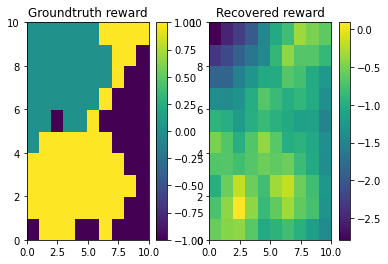

In [ ]:
def main(grid_size, discount, n_objects, n_colours, n_trajectories, epochs,
         learning_rate):
    """
    Run maximum entropy inverse reinforcement learning on the objectworld MDP.
    Plots the reward function.
    grid_size: Grid size. int.
    discount: MDP discount factor. float.
    n_objects: Number of objects. int.
    n_colours: Number of colours. int.
    n_trajectories: Number of sampled trajectories. int.
    epochs: Gradient descent iterations. int.
    learning_rate: Gradient descent learning rate. float.
    """

    wind = 0.3
    trajectory_length = 8

    ow = Objectworld(grid_size, n_objects, n_colours, wind,
                                 discount)
    ground_r = np.array([ow.reward(s) for s in range(ow.n_states)])
    policy = find_policy(ow.n_states, ow.n_actions, ow.transition_probability,
                         ground_r, ow.discount, stochastic=False)
    trajectories = ow.generate_trajectories(n_trajectories,
                                            trajectory_length,
                                            lambda s: policy[s])
    feature_matrix = ow.feature_matrix(discrete=False)
    r = irl(feature_matrix, ow.n_actions, discount,
        ow.transition_probability, trajectories, epochs, learning_rate)

    plt.subplot(1, 2, 1)
    plt.pcolor(ground_r.reshape((grid_size, grid_size)))
    plt.colorbar()
    plt.title("Groundtruth reward")
    plt.subplot(1, 2, 2)
    plt.pcolor(r.reshape((grid_size, grid_size)))
    plt.colorbar()
    plt.title("Recovered reward")
    plt.show()

if __name__ == '__main__':
    main(10, 0.9, 15, 2, 20, 50, 0.01)